# OD Analysis for Yeast States 1 0 Growth Curves

 Analyzed at 2021-04-21 17:32:28.302998 UTC

In [1]:
import sys
sys.executable

'/Users/rpg/.virtualenvs/xplan-od-growth-analysis/bin/python'

In [2]:
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xplan_od_growth_analysis as xod

In [6]:
import os
os.environ['SIFT_GA_MONGO_USER']

'WNCPXXd8ccpjs73zxyBV@catalog.sd2e.org'

In [7]:
df = pd.read_csv("/Users/rpg/projects/xplan/data/reactor_outputs/complete/YeastSTATES-1-0-Growth-Curves/20210330184118/YeastSTATES-1-0-Growth-Curves__platereader.csv")

df = xod.rectify_frame(df)

xod.read_credentials()

metadata = xod.ExperimentMetadata(experiment_reference="YeastSTATES-1-0-Growth-Curves", df=df)

# Summary Information

There are 1 plates in this experiment.

All of the strains were grown at 30 celsius.
In Synthetic_Complete media.The first post induction time point is 17 hour.
OD levels prior to this time point are unreliable.



# Examine the MediaControl OD values



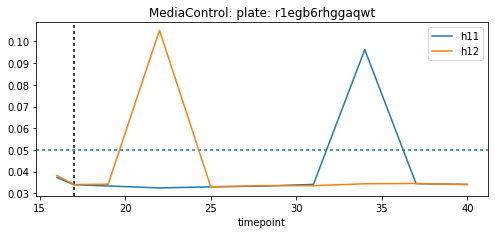

In [8]:
fig = xod.plot_control(control_name='MediaControl', df=df, metadata=metadata)


# Plot the full set of controls

Dashed horizontal line is the background (medium) OD level. 
Dashed vertical line is first post-induction OD measurement. 


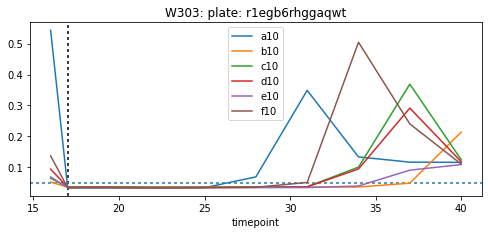

In [9]:
figs = xod.plot_all_controls(df, metadata, dont_plot=['MediaControl'])


# Plot raw OD data



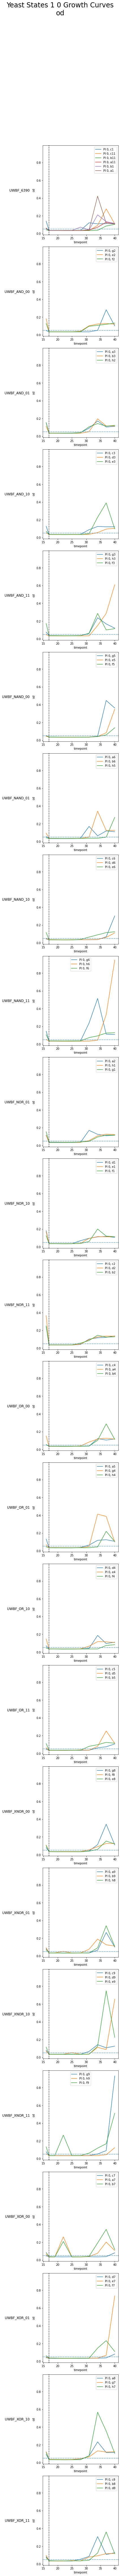

In [10]:
fig = xod.plot_output('od', df, metadata)


# Compute dead replicates based on background OD

Label as dead all replicates that do not exceed background (medium) OD.

In [11]:
dead_frame = xod.dead_frame(df=df, metadata=metadata)
dead_frame.head()


,,,max_od
experiment_id,strain,well,


# Compute non-growing replicates based on change in OD

Label as "ungrowing" all replicates that do not double in OD.

In [12]:
ungrowing_frame = xod.ungrowing_frame(df, metadata)
ungrowing_frame.head()


od_slope
experiment_id  strain       well          
r1egb6rhggaqwt UWBF_6390    b11   0.007759
               UWBF_AND_10  d3    0.007806
               UWBF_NAND_10 d6    0.008593
               UWBF_NOR_01  g1    0.009067
               UWBF_NOR_10  d1    0.009212

# Comparing the two criteria



In [13]:
set(dead_frame.index.values) - set(ungrowing_frame.index.values)


set()

In [14]:
set(ungrowing_frame.index.values) - set(dead_frame.index.values)


{('r1egb6rhggaqwt', 'UWBF_6390', 'b11'),
 ('r1egb6rhggaqwt', 'UWBF_AND_10', 'd3'),
 ('r1egb6rhggaqwt', 'UWBF_NAND_10', 'd6'),
 ('r1egb6rhggaqwt', 'UWBF_NOR_01', 'g1'),
 ('r1egb6rhggaqwt', 'UWBF_NOR_10', 'd1'),
 ('r1egb6rhggaqwt', 'UWBF_NOR_10', 'e1'),
 ('r1egb6rhggaqwt', 'UWBF_OR_10', 'e4'),
 ('r1egb6rhggaqwt', 'UWBF_OR_10', 'f4'),
 ('r1egb6rhggaqwt', 'UWBF_OR_11', 'b5'),
 ('r1egb6rhggaqwt', 'UWBF_OR_11', 'c5'),
 ('r1egb6rhggaqwt', 'UWBF_XOR_00', 'c7'),
 ('r1egb6rhggaqwt', 'UWBF_XOR_01', 'd7'),
 ('r1egb6rhggaqwt', 'UWBF_XOR_11', 'b8')}

# Count failed replicates by strain



In [15]:
failure_count_df = ungrowing_frame.groupby('strain').size().to_frame()
failure_count_df.columns = pd.Index(['failed_replicates'])
totals_df=df.query('strain in %s and timepoint == %d' % (metadata.experimental_strains, metadata.induction_timepoint))
totals_df = totals_df.groupby(['strain']).size().to_frame()
totals_df.columns = pd.Index(['total_replicates'])
display_failure_df = failure_count_df.join(totals_df, how='right')
display_failure_df = display_failure_df.fillna(0)
display_failure_df['proportion'] = display_failure_df['failed_replicates'] /display_failure_df['total_replicates']
display_failure_df = display_failure_df.rename({'failed_replicates': 'failed', 'total_replicates' : 'total'}, axis=1)
display_failure_df.style.format({'failed': '{:.0f}'.format, 'total': '{:.0f}'.format, 'proportion': '{:,.0%}'.format})

,failed,total,proportion
strain,,,
UWBF_6390,1,6,17%
UWBF_AND_00,0,3,0%
UWBF_AND_01,0,3,0%
UWBF_AND_10,1,3,33%
UWBF_AND_11,0,3,0%
UWBF_NAND_00,0,3,0%
UWBF_NAND_01,0,3,0%
UWBF_NAND_10,1,3,33%
UWBF_NAND_11,0,3,0%


# Count failed control replicates by strain



In [16]:
ungrowing_frame = xod.ungrowing_frame(df, metadata, strain_class='control')
failure_count_df = ungrowing_frame.groupby('strain').size().to_frame()
failure_count_df.columns = pd.Index(['failed_replicates'])
totals_df=df.query('strain in %s and timepoint == %d' % (metadata.controls, metadata.induction_timepoint))
totals_df = totals_df.groupby(['strain']).size().to_frame()
totals_df.columns = pd.Index(['total_replicates'])
display_failure_df = failure_count_df.join(totals_df, how='right')
display_failure_df = display_failure_df.fillna(0)
display_failure_df['proportion'] = display_failure_df['failed_replicates'] /display_failure_df['total_replicates']
display_failure_df = display_failure_df.rename({'failed_replicates': 'failed', 'total_replicates' : 'total'}, axis=1)
display_failure_df.style.format({'failed': '{:.0f}'.format, 'total': '{:.0f}'.format, 'proportion': '{:,.0%}'.format})
 

,failed,total,proportion
strain,,,
MediaControl,0,2,0%
W303,1,6,17%


# Count failed replicates by plate



In [17]:
ungrowing_frame = xod.ungrowing_frame(df, metadata, strain_class='both')
ungrowing_frame.reset_index(['strain', 'well'], inplace=True)
failure_count_df = ungrowing_frame.groupby('experiment_id').size().to_frame()
failure_count_df.columns = pd.Index(['failed_replicates'])

totals_df = df.query('timepoint == %d' % (metadata.induction_timepoint))
totals_df = totals_df.groupby(['experiment_id']).size().to_frame()
totals_df.columns = pd.Index(['total_replicates'])
display_failure_df = failure_count_df.join(totals_df, how='inner')
display_failure_df['proportion'] = display_failure_df['failed_replicates'] / display_failure_df['total_replicates']
display_failure_df = display_failure_df.rename({'failed_replicates': 'failed', 'total_replicates': 'total'}, axis=1)
display_failure_df.style.format({'failed': '{:.0f}'.format, 'total': '{:.0f}'.format, 'proportion': '{:,.0%}'.format})

,failed,total,proportion
experiment_id,,,
r1egb6rhggaqwt,14,83,17%


# Plot growth curves with non-growing replicates removed


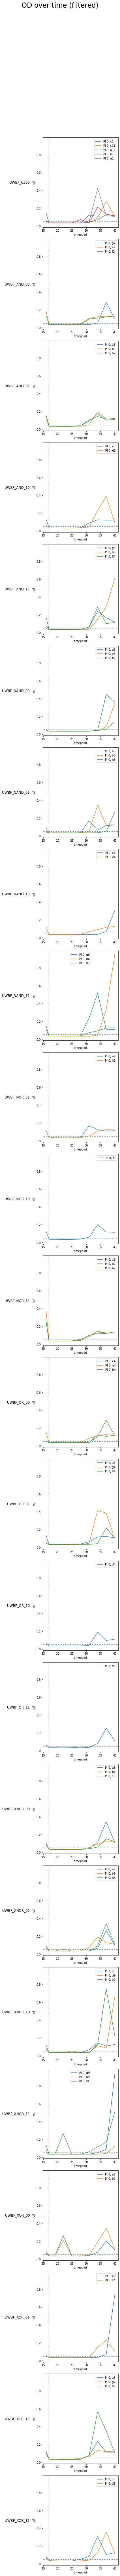

In [18]:
ungrowing_frame = xod.ungrowing_frame(df, metadata, strain_class='both')
fig = xod.plot_output('od', metadata=metadata, df=df, filter=ungrowing_frame.reset_index('strain'), title="OD over time (filtered)")


# Fit exponential to find doubling times


In [19]:
filtered_df = xod.filter_df(df, metadata, ungrowing_frame.reset_index('strain').index)
time_series_data_frame = xod.time_series_df(filtered_df)
records = dict()
for strain, strain_values in time_series_data_frame.groupby(['strain']):
    i = 0
    for conds, values in strain_values.groupby(['experiment_id', 'well']):
        i += 1
        records[(strain, i, conds[0], conds[1])] = {'start_od': values['od'][0], 'max_od': values['od'].max(), 'growth': values['od'].max() - values['od'][0]}
od_change_dataframe = pd.DataFrame.from_dict(records).transpose()
od_change_dataframe.rename_axis(['strain', 'replicate', 'plate', 'well'], axis=0, inplace=True)
pretty = copy.deepcopy(od_change_dataframe)
pretty.index = pretty.index.droplevel('plate').droplevel('well')
filtered_od_change_dataframe = od_change_dataframe.query(f'max_od > %f and growth > %f' %(metadata.background_od, metadata.background_od))
print('Total number of replicates for computing doubling rates = %d' % filtered_od_change_dataframe.shape[0])
print('Total number of replicates = %d'%od_change_dataframe.shape[0])


Total number of replicates for computing doubling rates = 46
Total number of replicates = 62


In [20]:
doubling_time_df = xod.doubling_time_df(time_series_data_frame, metadata)
doubling_time_df = xod.restore_columns(doubling_time_df, df[['experiment_id', 'well', 'strain']].drop_duplicates())


In [21]:
pd.set_option('precision', 2)
strain_dts = doubling_time_df.groupby(['strain']).agg(mean=('doubling_time', np.mean), std=('doubling_time', np.std))
display(strain_dts)


,mean,std
strain,,
UWBF_6390,1.21e+01,4.02e+00
UWBF_AND_00,1.48e+01,6.96e+00
UWBF_AND_01,1.70e+01,3.41e+00
UWBF_AND_10,1.19e+01,4.42e+00
UWBF_AND_11,1.04e+01,7.43e+00
UWBF_NAND_00,5.15e+00,4.04e+00
UWBF_NAND_01,8.80e+00,6.37e+00
UWBF_NAND_10,7.88e+00,8.81e+00
UWBF_NAND_11,1.00e+01,7.14e+00


# Remove all doubling times greater than 100h


In [22]:
pd.set_option('precision', 0)
strain_dts1 = doubling_time_df.query('doubling_time < 100').groupby(['strain']).agg(mean=('doubling_time', np.mean), std=('doubling_time', np.std), samples=('doubling_time', len))
display(strain_dts1)


,mean,std,samples
strain,,,
UWBF_6390,12,4,5
UWBF_AND_00,15,7,3
UWBF_AND_01,17,3,3
UWBF_AND_10,12,4,2
UWBF_AND_11,10,7,3
UWBF_NAND_00,5,4,3
UWBF_NAND_01,9,6,3
UWBF_NAND_10,8,9,2
UWBF_NAND_11,10,7,3
